In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import time
import requests
from datetime import datetime, timedelta
from shapely.geometry import Point
from busSim import BusSim
from graph import Graph
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import pairwise_distances
from constrained_kmedoids import KMedoids
import itertools

In [2]:
# from shapely import wkt
# df = pd.read_csv("NarrowFactors.csv")
# df['geometry'] = df['geometry'].apply(wkt.loads)
# gdf = gpd.GeoDataFrame(df, crs='epsg:4326')

In [3]:
# from sklearn import preprocessing
# # cite from https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc
# # Get column names first
# dfFactors = pd.read_csv("NarrowFactors.csv")
# df = dfFactors.iloc[:,2:-1]
# names = df.columns
# # Create the Scaler object
# scaler = preprocessing.StandardScaler()
# # Fit your data on the scaler object
# scaled_df = scaler.fit_transform(df)
# scaled_df = pd.DataFrame(scaled_df, columns=names)
# dfFactors.iloc[:,2:-1] = scaled_df


In [8]:
df_cen = gpd.read_file("zip://plot/background/SCORE.zip")
df_cen.columns

Index(['GEOID10', 'TotalPopul', 'Preschool', 'Pgradeschl', 'Teen', 'Senior',
       'White', 'Black', 'AmeriIndia', 'Asian alon', 'Islander', 'otherRace',
       'PPreschool', 'PGradesch', 'PTeen', 'PSenior', 'PWhite', 'PBlack',
       'PAsian', 'totalEduc', 'School', 'FamilyNum', 'underPov', 'PEducation',
       'PPoverty', 'SCORE', 'Distance', 'popuDensit', 'geometry'],
      dtype='object')

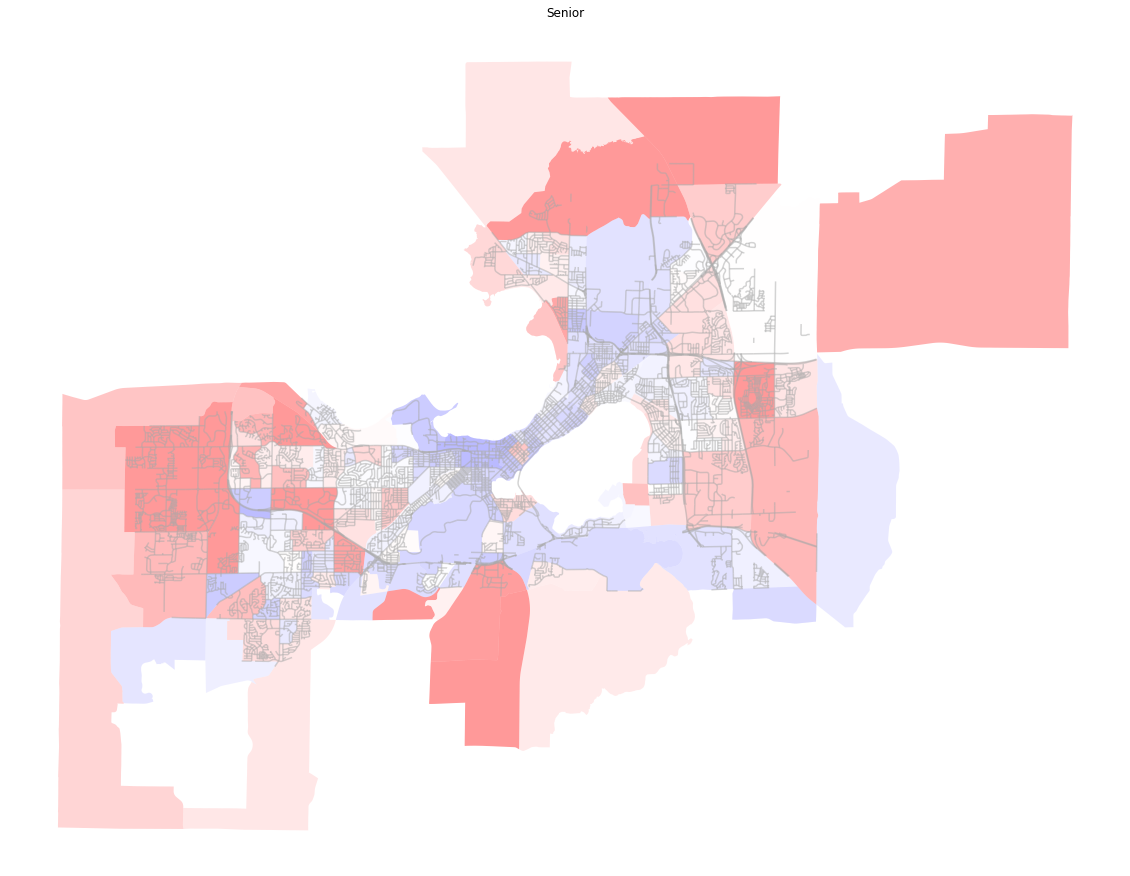

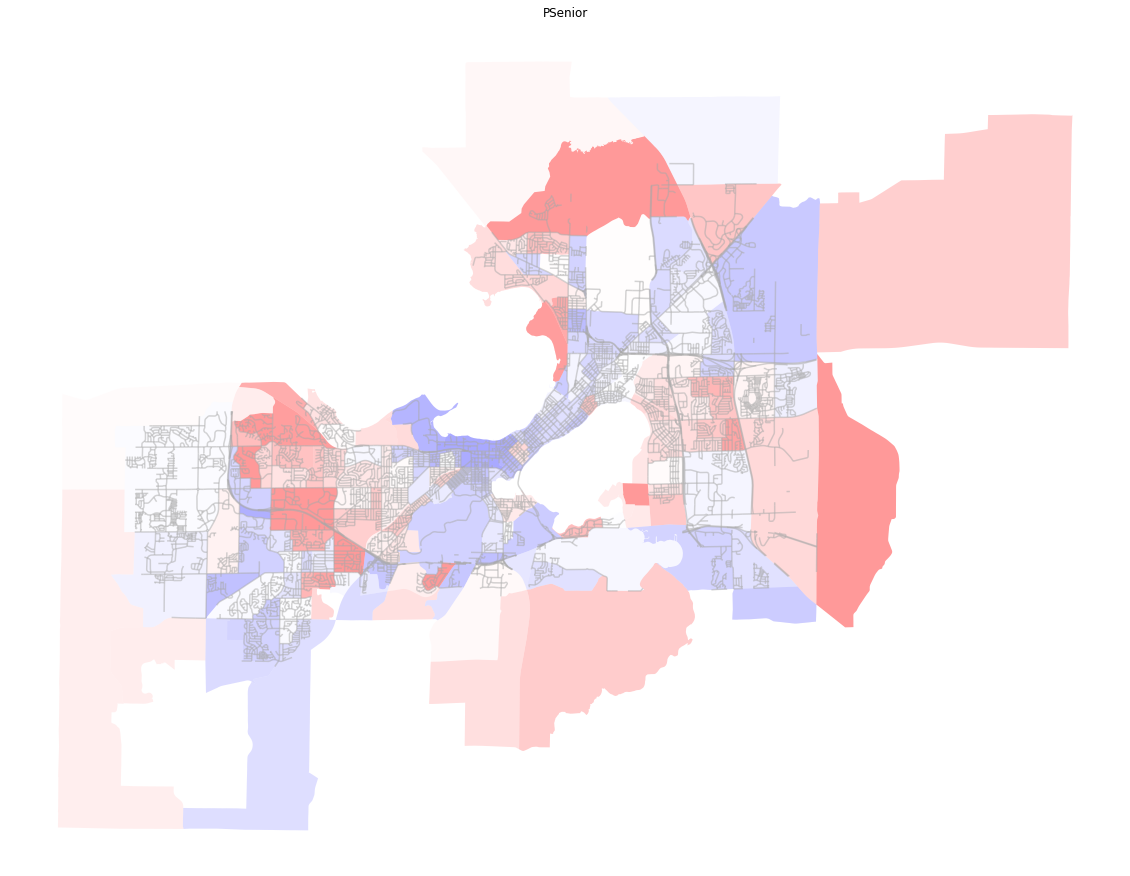

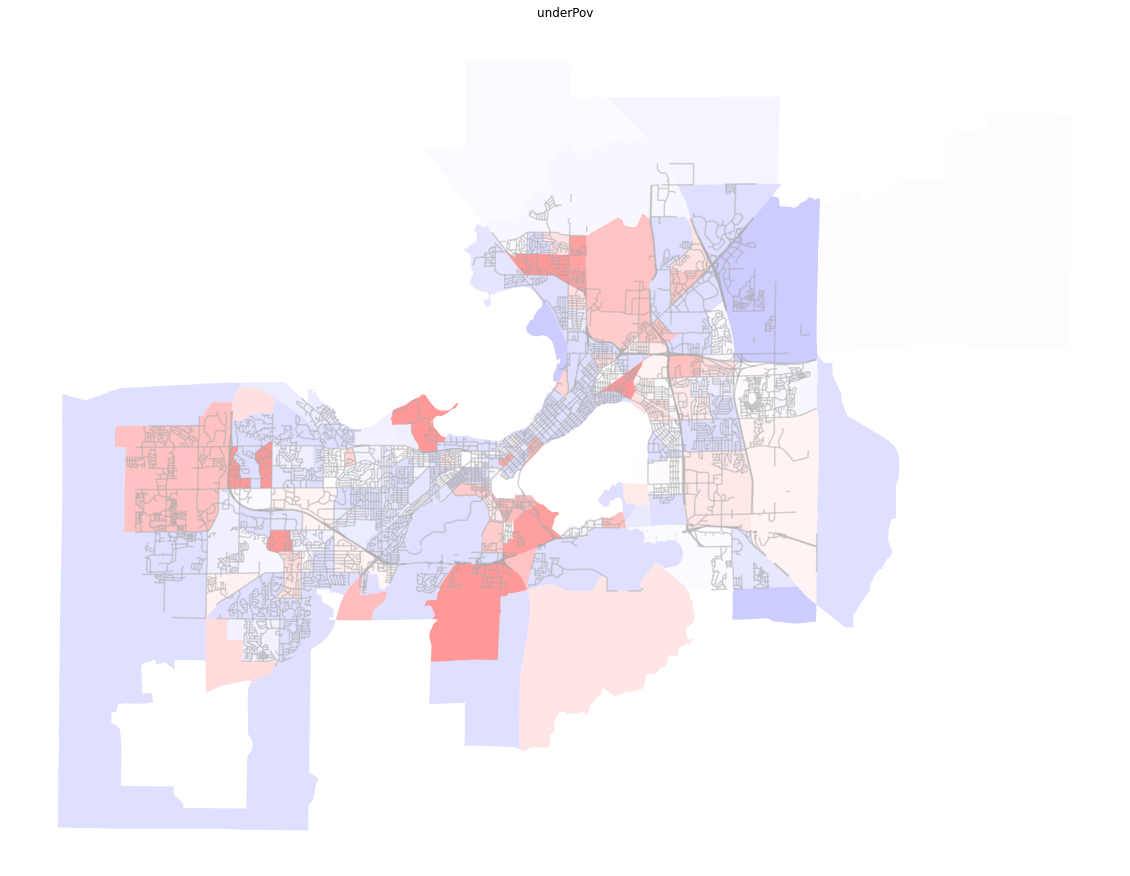

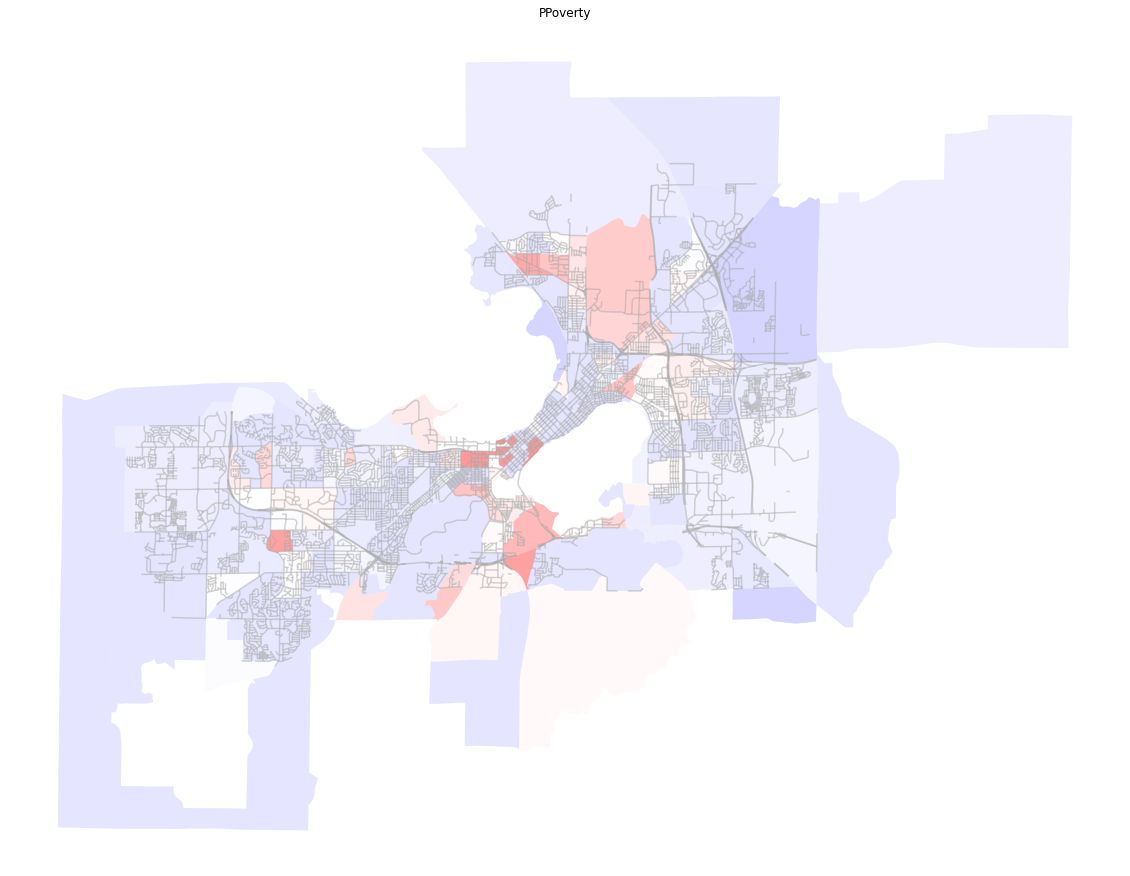

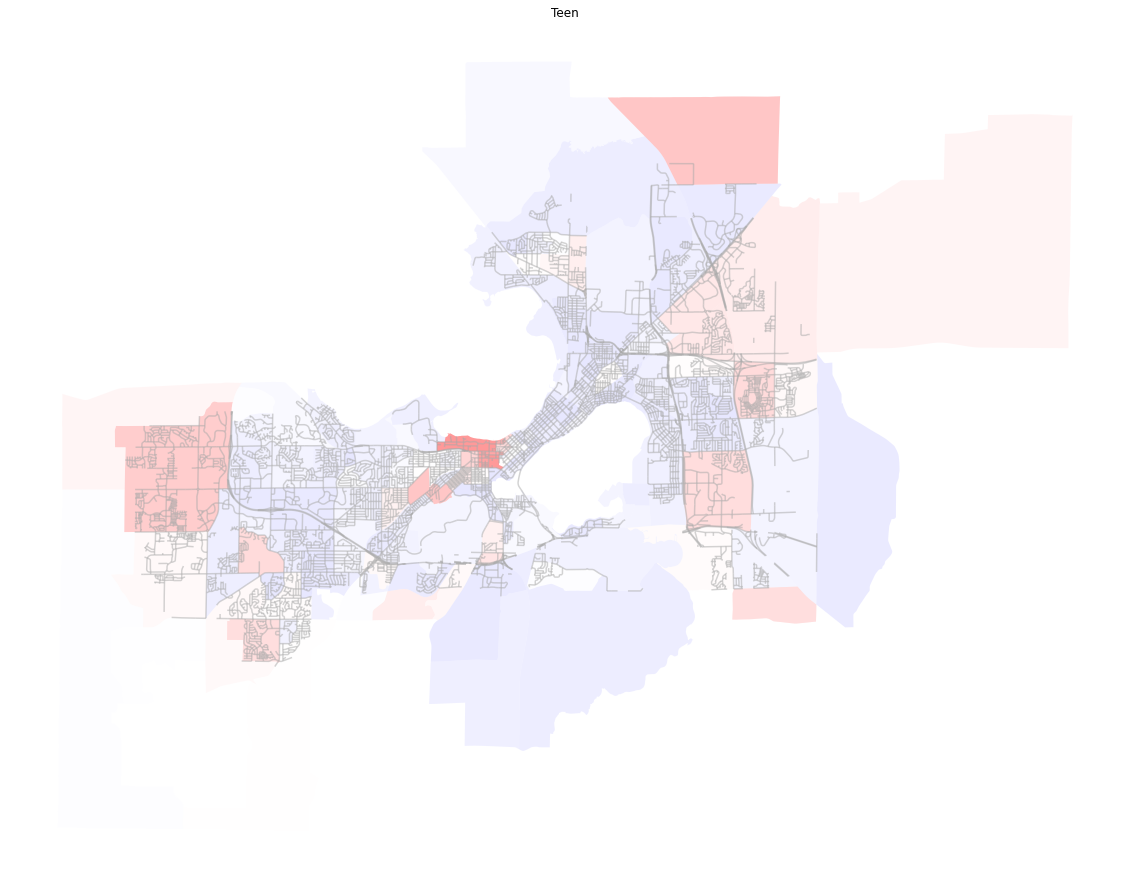

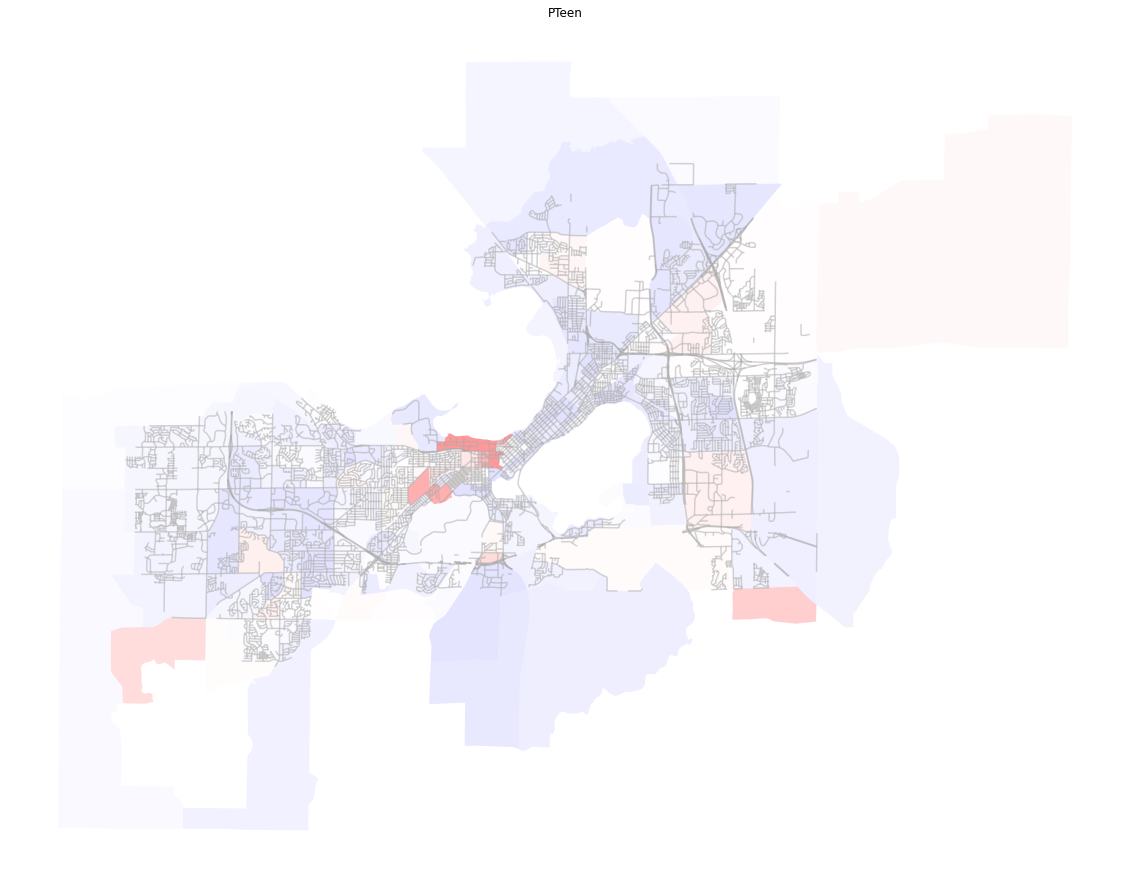

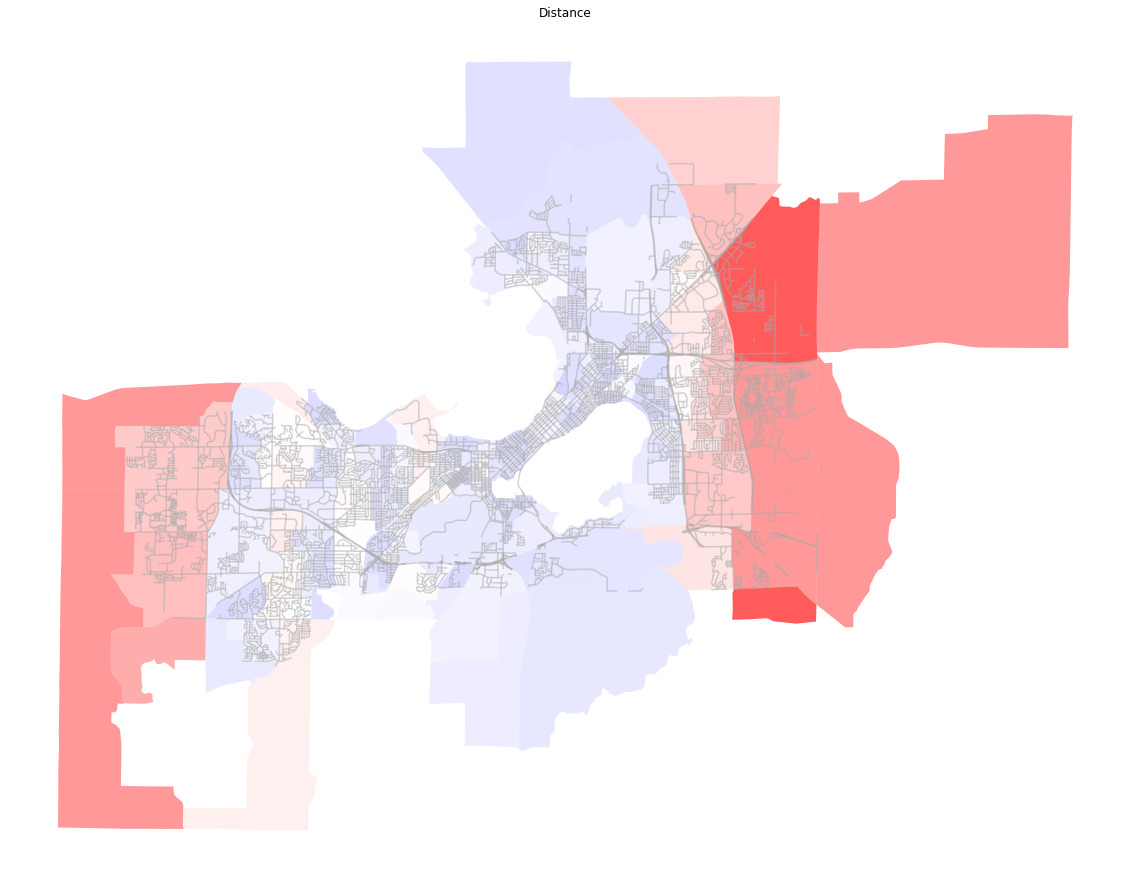

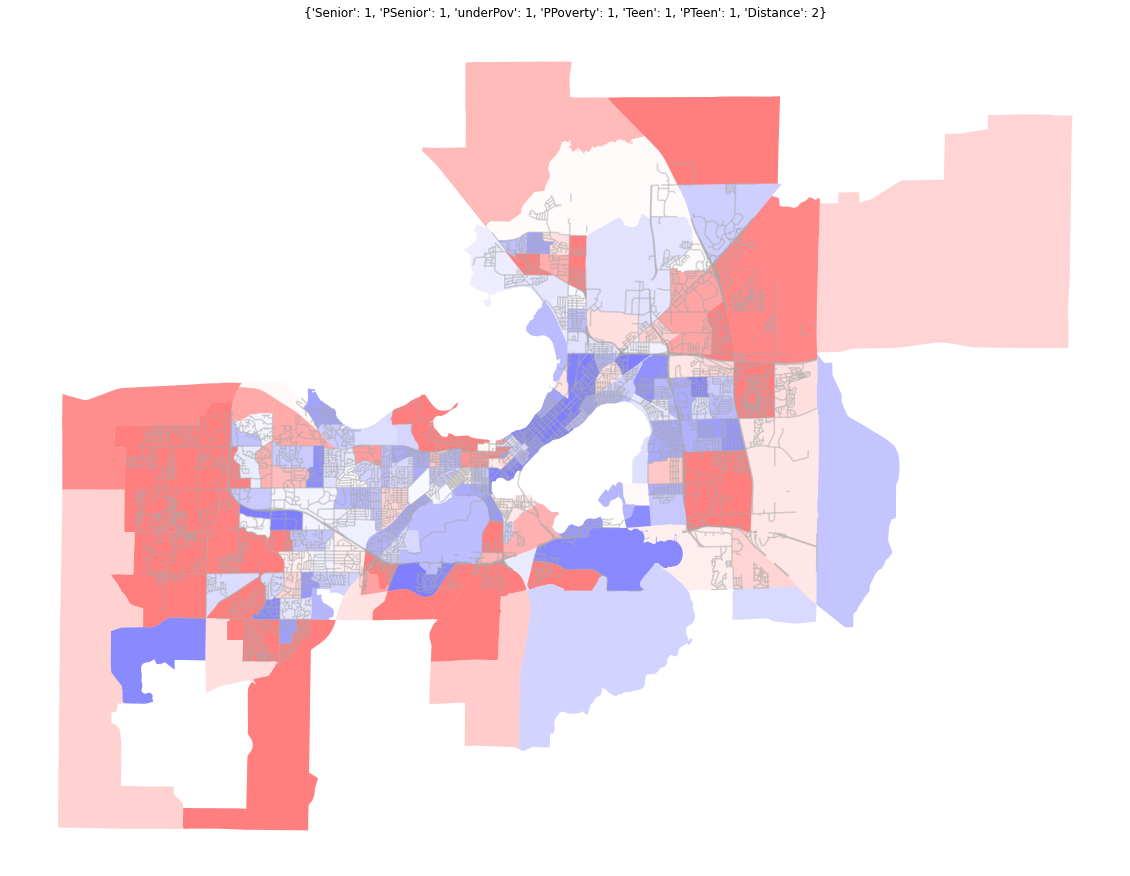

In [28]:
ax,df,df_all = utilityMap({"Senior":1,"PSenior":1,"underPov":1,"PPoverty":1,'Teen':1,'PTeen':1,
                           'Distance':2},12)

In [27]:
def single_map(name):
    
    # load data from plot data from file
    street = gpd.read_file("./plot/background/street-shp")
    df_cen = gpd.read_file("zip://plot/background/SCORE.zip")
    gdf = gpd.GeoDataFrame(df_cen, geometry=df_cen.geometry)
    
    #menu = pd.read_csv("menu.csv")
    #cato = int(menu[menu.name == name].index.values)
#     key = menu.loc[cato,"key"]
    #fullName = menu.loc[cato,"full_name"]
    
    ax=gdf.plot(column=name, cmap='bwr',figsize=(20,16),alpha=0.4
                 ,legend_kwds={'orientation': "horizontal",
                    'shrink': 0.5,'alpha':0.45,'pad':0.01},vmin=-2, vmax=2)
    fig = ax.figure
    #cb_ax = fig.axes[1] 
    #cb_ax.tick_params(labelsize=20)
    street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)
    ax.set_axis_off()    
    ax.title.set_text(name)
    
    return ax
    


In [26]:
def combine_map(catodic,number):
    
    ratioSum = sum(catodic.values())
    
    processDic = {}
    for key,value in catodic.items():
        processDic[key] = value/ratioSum
        
    # load data from plot data from file
    street = gpd.read_file("./plot/background/street-shp")
    df_cen = gpd.read_file("zip://plot/background/SCORE.zip")
    #df_cen["transport"] = -df_cen["transport"]
    
    #menu = pd.read_csv("menu.csv")
    df_cen['utility_map'] = 0
    
    # construct the utility function
    for key in processDic.keys():
        #key = menu.loc[cato,"key"]
        df_cen['utility_map'] += processDic[key]*df_cen[key]
    df_all = df_cen
    df_cen = df_cen.sort_values('SCORE',ascending=False)
    gdf = gpd.GeoDataFrame(df_all, geometry=df_all.geometry)
    ax=gdf.plot(column='SCORE', cmap='bwr',figsize=(20,16),alpha=0.5
                 ,legend_kwds={'orientation': "horizontal",
                    'shrink': 0.5,'alpha':0.5,'pad':0.01},vmin=-10, vmax=10)
    fig = ax.figure
    df_cen = df_cen[df_cen['utility_map']>0]
    #cb_ax = fig.axes[1] 
    #cb_ax.tick_params(labelsize=20)   
    street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)
    ax.title.set_text(catodic)
    ax.set_axis_off()
    return ax,df_cen,df_all
    


In [5]:
def utilityMap(catodic,number):
    for each in catodic.keys():
        single_map(each)
#     plt.subplot(211)
#     fig, (ax0, ax1) = plt.subplots(nrows=2)
    ax,df_cen, df_all = combine_map(catodic,number)
    df_cen = df_cen.head(number)
    #print(len(df_cen))
    x=np.arange(1,len(df_cen)+1)
    SCORE=df_cen['SCORE']
    pdfS=SCORE/np.sum(SCORE)
    cdfS=np.cumsum(pdfS)

    utility = df_cen['utility_map']
    pdfU=utility/np.sum(utility)
    cdfU=np.cumsum(pdfU)
    #ax1 = plt.subplot()
    #plt.plot(x,pdf, marker="o",label="PMF")
    #fig, ax1 = plt.subplots(nrows=1)
    #figsize = (16,16)
    #ax1.plot(x,cdfU,marker="o",label="utility")
    #ax1.plot(x,cdfS,marker="o",label="score")
    #plt.xlim(0,len(df_cen))
    #plt.ylim(0,100)
    plt.xlabel("X")
    #plt.ylabel("Probability Values")
    #plt.title("CDF for discrete distribution")
    #plt.legend()
    #plt.show()
    #print(df_cen[['SCORE','utility_map']])
    df_all = df_all.reset_index().rename(columns={"index":"geoID"})
    df_cen = df_cen.reset_index().rename(columns={"index":"geoID"})
    return ax,df_cen,df_all

In [29]:
def outpoint(df):
    df_distance=[]
    for j in range(len(df)):
        delhi_1 = (df['centroid'].iloc[j].x, df['centroid'].iloc[j].y)
        df_distance.append(delhi_1)
    df['location']=df_distance
    return df

In [30]:
def lonlat(df):
    df["centroid"] = df.centroid
    df_lon=[]
    df_lat = []
    for j in range(len(df)):
        delhi_lon,delhi_lat = df['centroid'].iloc[j].x, df['centroid'].iloc[j].y
        df_lon.append(delhi_lon)
        df_lat.append(delhi_lat)
    df['lon']=df_lon
    df['lat']=df_lat
    df = outpoint(df)
    return df

In [31]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

#y = df_all[["utility_map","SCORE"]]
#df_cen = df_all[df_all['utility_map']>0]
def score_regression(df_all):
    x = df_all["SCORE"]
    y = df_all["utility_map"]  
    x = sm.add_constant(x) 
    model = sm.OLS(y, x).fit() 
    #print(model.summary()) 
    #print(model.pvalues)

    predicts = model.predict() 
    
    x = df_all["SCORE"]  
    #plt.scatter(x, y, label='fact') 
    #plt.plot(x, predicts, color = 'red', label='predict')
    #plt.legend() 
    #plt.show() 
    
    return model.params["SCORE"],model.params["const"]


In [32]:
#df["Estimated_Improved"] = model.params["SCORE"]*df["SCORE"]+model.params["const"]
#df["Estimated_Improved"].sum()

In [33]:
def route_listx(df):
    a=[]
    for i in range(len(df)):
        a.append(df['centroid'].iloc[i].x)
    return a
    
def route_listy(df):
    a=[]
    for i in range(len(df)):
        a.append(df['centroid'].iloc[i].y)
    return a

def plot_line_arrow(ax,df,color,zorder=2):
    
    x = route_listx(df)
    y = route_listy(df)

    u = np.array([x[i+1]-x[i] for i in range(len(x)-1)])
    v = np.array([y[i+1]-y[i] for i in range(len(x)-1)])

    x = x[:len(u)] 
    y = y[:len(v)]

    ax.quiver(x,y,u,v,angles='xy', scale_units='xy', scale=1,
          headaxislength=5.5,headlength=10,headwidth=20,width=0.002,color=color)
    
def plot_line(ax,df,color,zorder=2):
    
    x = route_listx(df)
    y = route_listy(df)

    u = np.array([x[i+1]-x[i] for i in range(len(x)-1)])
    v = np.array([y[i+1]-y[i] for i in range(len(x)-1)])

    x = x[:len(u)] 
    y = y[:len(v)]

    ax.quiver(x,y,u,v,angles='xy', scale_units='xy', 
              scale=1,headaxislength=0,headlength=0,headwidth=0,width=0.002,color=color)

In [34]:
def compare_list(list1, list2):
    a=[]
    for i in range(len(list1)):
            if list1[i] == list2[i]:
                a.append(list1[i])
    return a

In [35]:
from ScoreSchedule import scoreSchedule

ModuleNotFoundError: No module named 'ScoreSchedule'

In [261]:
scoreSchedule(schedule)

AttributeError: 'scoreSchedule' object has no attribute '_dfScoreGen'

In [105]:
df = pd.DataFrame(orginialSchedule.stack().value_counts(),columns=["frequency"])

In [237]:
utilityOrder(orginialSchedule)

1

In [262]:
orginialSchedule.to_csv("orgSchedule.csv")

In [36]:
def utilityOrder(df):
        
    idealorder = [0,1,2,4,3]
    df_frequency = pd.DataFrame(df.stack().value_counts(),columns=["frequency"])
    scheduleUti = []
    
    weekday = ['Friday','Thursday','Wednesday', 'Tuesday','Monday']
    for day in weekday:
        uti = 0
        for each in df[day]:
            if each >0:
                uti += float(df_all.loc[each,"utility_map"]**1/(df_frequency.loc[each]))
                df_frequency.loc[each] -= 1
        scheduleUti.append(uti)
    dayUti = pd.DataFrame(scheduleUti[::-1],columns=["uti"],index=range(5))
    orderlist = dayUti.sort_values("uti",ascending = False).index.to_list()
    
    result = compare_list(idealorder, orderlist)
    
    return len(result)

In [37]:
list1 = [1.5558955396112006, 1.465470468989024, 1.4543478855558503, 0.6756268550899599, 1.0114487867437578]
#list2 = [1,2,4,3,5]
pd.DataFrame(list1,columns=["uti"]).sort_values("uti",ascending = False)

uti
0  1.555896
1  1.465470
2  1.454348
4  1.011449
3  0.675627

In [38]:
df_all.loc[44,"utility_map"]

-0.34582971813093105

In [13]:
def wkd_score(df):
    score = gpd.read_file("zip://plot/background/SCORE.zip")
    weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekindex = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4}
    scoredict = {}
    for idx,row in score.iterrows():
        scoredict[row['Unnamed: 0']] = row["SCORE"]
    Msum = 0
    for each in list_loc:
        Msum += scoredict[int(each)]
    return int(Msum)

In [39]:
df2 = df.to_crs("epsg:32616")
test = lonlat(df2)
locationxy = []
for idx,row in df2.iterrows():
    locationxy.append([row['lon'],row['lat']])
#df["xy"] = locationxy

# generate random points
X = np.array(locationxy)

# compute distance matrix

dist = pairwise_distances(X, metric='euclidean')

# k-medoids algorithm

times = 1
track = []
while times<100:
    km = KMedoids(distance_matrix=dist, n_clusters=5)
    km.run(max_iterations=1000000, tolerance=0.00000001)
    track.append(km.clusters)
    times += 1
    
temp = []
for item in track:
    if not item in temp:
        temp.append(item)
        

resultlist = []
for result in temp:
    addressdict = {}
    i = 0
    for each in locationxy:
        addressdict[i] = each
        i += 1

    for key,value in result.items():
        result[key] = list(value)

    adddf = pd.DataFrame.from_dict(addressdict).T

    labellist = list(range(12))

    num = 1

    for key,value in result.items():
        for each in value:
            i = each
            labellist[i] = num
        num +=1
        
    resultlist.append(labellist)
    
    

In [40]:
resultlist

[[1, 5, 3, 2, 1, 2, 4, 3, 4, 2, 1, 5],
 [3, 1, 2, 2, 3, 4, 5, 1, 5, 2, 4, 1],
 [1, 5, 4, 2, 1, 2, 3, 4, 3, 2, 1, 5],
 [3, 1, 2, 2, 3, 4, 5, 1, 5, 2, 4, 1],
 [5, 3, 1, 1, 1, 4, 2, 3, 2, 4, 5, 2],
 [1, 2, 1, 3, 1, 5, 4, 2, 4, 3, 5, 2]]

In [41]:
def list_route(group_number,group_table): # generate all possible routes for one day
    each_route=[]
    for i in range(len(group_table)):
        if group_table['label'].iloc[i]==group_number:
            each_route.append(i)
    possible_route=list(itertools.permutations(each_route))
    return possible_route


def best_route(group_number,group_table,distMatrix = dist): # generate the route with the smallest total distance for each day
    route_dictionary={}    
    distance = pd.DataFrame(distMatrix)
    for i in range(len(list_route(group_number,group_table))):
        route=list_route(group_number,group_table)[i]
        dist=0
        for j in range(len(route)):
            if j+1<len(route):
                dist+=distance.iloc[route[j],route[j+1]] 
        route_dictionary[route]=dist

    minimum_distance = min(route_dictionary.values())
    minimum_route = [key for key in route_dictionary if route_dictionary[key] == minimum_distance][0]
    return minimum_route

def totalroute_each_day(group_number,group_table): # generate the total route for each day with its total score
    score=0
    total_route=[]
    total_score=[]
    for i in range(len(best_route(group_number,group_table))):
        for j in range(len(df2)):
            if best_route(group_number,group_table)[i]==j:
                score=df2['utility_map'].iloc[j]
                name=df2['geoID'].iloc[j]
                total_route.append(name)
                total_score.append(score)
    return total_route, sum(total_score)

def sorted_route_by_score(group_table): # generate sorted dataframe of five days, and sorted dataframe for total circulation
    route_list=[]
    for i in range(5):
        route_list.append(totalroute_each_day(i+1,group_table)[0]) # collect five days' route together
    score_list=[]
    for i in range(5):
        score_list.append(totalroute_each_day(i+1,group_table)[1]) # collect five days' score together
    
    dict_ab={'schedule':route_list,'score':score_list}
    df_route_score=pd.DataFrame.from_dict(dict_ab, orient='index') # generate the dataframe of each route with its score for each day
    df_route_score=df_route_score.T
    df_route_score=df_route_score.sort_values(by=['score'],ascending=False) # sort the route of each day by score
    total_circluation = pd.read_csv("TotalCir.csv")
    circluation=total_circluation.sort_values(by=['Total Circulation'],ascending=False) # sort the circulation of each day 
    return df_route_score, circluation 

def match_weekdays(group_table): # Match the route from large to small with the weekdays by its score
    df_route_score=sorted_route_by_score(group_table)[0]
    circluation=sorted_route_by_score(group_table)[1]
    weekdays=['Mondays','Tuesdays','Wednesdays','Thursdays','Fridays']
    matched_route={}
    for i in range(len(circluation)):
        for j in range(len(weekdays)):
            if circluation['Unnamed: 0'].iloc[i]==weekdays[j]:
                matched_route[weekdays[j]]=df_route_score['schedule'].iloc[i]
    return matched_route

def createSchedule(Monday,Tuesday,Wednesday,Thursday,Friday): # create the framework of the schedule
    weekin = {'Monday':Monday, 'Tuesday':Tuesday, 'Wednesday':Wednesday, 'Thursday':Thursday, 'Friday':Friday}
    daylist = ['1pm','2pm',"3pm","4pm"]
    length = max(len(Monday),len(Tuesday),len(Wednesday),len(Thursday),len(Friday))
    schedule_initial = pd.DataFrame.from_dict(weekin,orient='index',columns=daylist[:length]).T
    return schedule_initial

def Auto_schedule(group_table): # Automatcially generate the final schedule
    schedule=createSchedule(match_weekdays(group_table)['Mondays'],match_weekdays(group_table)['Tuesdays'],match_weekdays(group_table)['Wednesdays'],match_weekdays(group_table)['Thursdays'],match_weekdays(group_table)['Fridays'])
    return schedule
orginialSchedule = createSchedule([81,44,44,194],[76,83],[124,124],[136,132],[26,25])

def best_distance(group_number,group_table,distMatrix = dist): # generate the route with the smallest total distance for each day
    route_dictionary={}    
    distance = pd.DataFrame(distMatrix)
    for i in range(len(list_route(group_number,group_table))):
        route=list_route(group_number,group_table)[i]
        dist=0
        for j in range(len(route)):
            if j+1<len(route):
                dist+=distance.iloc[route[j],route[j+1]] 
        route_dictionary[route]=dist

    minimum_distance = min(route_dictionary.values())
    minimum_route = [key for key in route_dictionary if route_dictionary[key] == minimum_distance][0]
    return minimum_distance
def total_dis(group_table):
    total=0
    for i in range(5):
        totaldist=best_distance(i+1,group_table)
        total+=totaldist
    return total

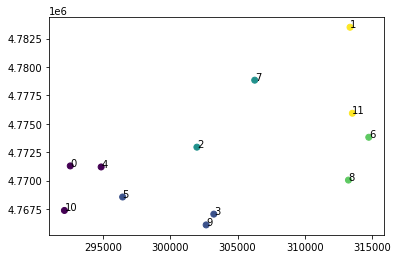

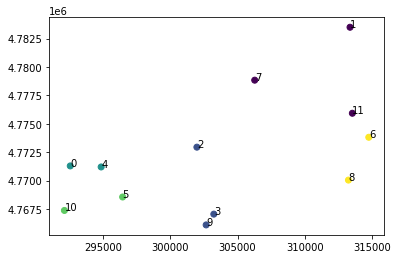

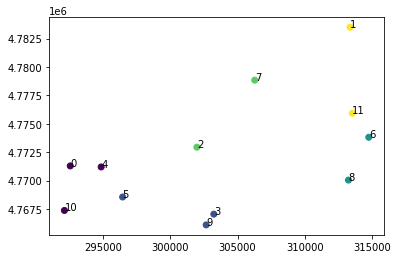

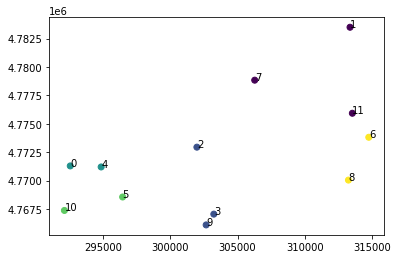

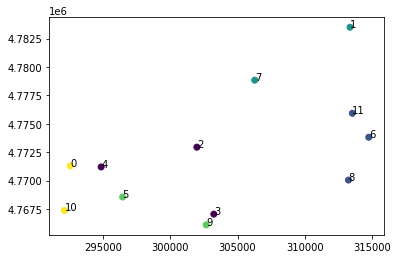

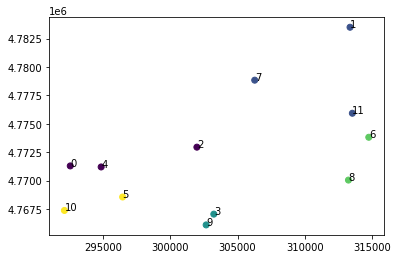

In [42]:
for labellist in resultlist:

    data_X, data_Y=[],[]
    for x,y in X:
        data_X.append(x)
        data_Y.append(y)

    n=np.arange(12)
    for k in range(len(data_X)):
        plt.text(data_X[k],data_Y[k],str(k))

    plt.scatter(data_X, data_Y, c=labellist)
    plt.show()

In [25]:
def createSchedule(Monday,Tuesday,Wednesday,Thursday,Friday,timeslot = ["2:00-3:00pm","3:30-4:30pm","5:00-6:00pm","6:30-8:00pm"]):
    weekin = {'Monday':Monday, 'Tuesday':Tuesday, 'Wednesday':Wednesday, 'Thursday':Thursday, 'Friday':Friday}
    for weekday,dayData in weekin.items():
        
        
        df = pd.DataFrame.from_dict(weekin,orient='index',columns=pd.date_range(start="12:00:00", freq='0.5H',periods=12).time).T
    return df

In [26]:
df_all.iloc[[15,17,20]]["SCORE"].max()

-1.834702308406789

In [27]:
df_all.iloc[[15,17,20]]["SCORE"].min()

-4.504645873331139

In [43]:
def diminishValue(df,value="SCORE"):
    
    # df: input df schedule
    # also support diminish value as "utility"
    
    df = pd.DataFrame(df.stack().value_counts(),columns=["frequency"])
    score = 0
    for idx,row in df.iterrows():
        for i in range(row["frequency"]):
            score += df_all.loc[int(idx),value]**1/(i+1)
    return score

In [30]:
cdf = createSchedule(['15','12','1','2','4','2','4','2','4','2','4','2'],
                     ['1','2','4','2','4','2','4','2','4','2','4','4'], ['5','6','7','15','4','2','4','2','4','2','4','4'],['8','9','10','4','2','4','2','4','2','4','4','4'],['11','12','13','14','2','4','2','4','2','4','4','4'])

In [154]:
df2

geoID       GEOID10  Total Popu  Preschool  Gradeschoo      Teen  \
0     180  550250109011    6.477993   3.659238    5.543151  0.979076   
1     194  550250114023    5.636446   4.608138    5.703409  1.107733   
2     160  550250032001    1.260827   2.754992    1.512037 -0.303469   
3      76  550250014023    0.765675   2.096344    1.721606  0.094563   
4       8  550250002043    1.572157   3.536439    0.667599 -0.307489   
5      26  550250004072    0.320463   2.140998    1.598330 -0.319551   
6     189  550250114012    2.852541   0.622758    2.843414  0.689599   
7     124  550250023011    0.280085   1.627475    1.752425  0.026214   
8     179  550250108005    3.066116   2.978263    1.925011  0.629291   
9     158  550250031003    1.361771   1.437695    2.190053  0.669497   
10     79  550250014032    1.147134   1.716784    1.567511  0.146829   
11    181  550250109031    2.048184   1.817255    1.444236  0.102604   
12    174  550250107021    1.731541   3.904836    2.091433  0.010132   
13    139  550250026031    1.713478   1.828419    1.641477  0.432286   
14     72  550250014013    0.626480   1.024645    1.715442  0.263424   
15     41  550250005043    1.521154   1.605148    1.493546  0.102604   
16     78  550250014031    1.351145   0.064581    1.561348  0.347855   
17    130  550250024021    0.708297   1.058135    1.308633  0.307650   
18     43  550250006001    0.645606   1.527004    2.584536  0.098583   

      Senior     White  Black or A  American I  ...  under pove  Education  \
0   5.256738  5.756173    0.383911   -0.259634  ...    1.193799  -0.188332   
1   4.088533  6.255652   -0.431085   -0.379007  ...   -0.183962  -0.080156   
2  -0.984685 -0.408984    2.131318    5.888031  ...    2.602873   1.047251   
3  -0.607844 -0.433088    3.547201    6.425206  ...    3.510943   0.285002   
4   0.174100  0.053001    1.067679    2.068122  ...    2.759437  -0.438321   
5  -0.127372 -0.600473    6.413500   -0.379007  ...    5.702836   0.206942   
6   2.920327  2.974889    1.157467   -0.379007  ...    0.066540  -0.230470   
7  -0.410003 -0.667428    4.224062   -0.379007  ...    5.264458   0.660751   
8   0.645151  3.266810    0.522046   -0.379007  ...   -0.277901  -0.218065   
9   0.989018  1.295674    1.060773    1.411576  ...    0.442293   0.180210   
10  0.263600 -0.007258    2.283267   -0.379007  ...    4.199824   0.064520   
11  1.342306  2.396403   -0.734981    3.261844  ...   -0.622341  -0.503705   
12  0.466152  2.022798   -0.134094   -0.379007  ...   -0.622341   0.009198   
13  0.456731  1.330490    1.820515   -0.379007  ...   -0.121337  -0.173370   
14  0.164679 -0.305874    2.276360   -0.379007  ...    0.974610   0.243494   
15  1.248096  1.355933    2.020810   -0.379007  ...   -0.622341   0.094111   
16  2.194908  1.074725    1.046959   -0.379007  ...   -0.622341  -0.076308   
17 -0.334634  0.127990    2.366147    0.038796  ...    1.820054   0.219090   
18 -0.631396 -0.497364    1.509711    0.516285  ...    0.191791   0.649134   

    Poverty Pe      SCORE                                           geometry  \
0    -0.343125  51.385288  POLYGON ((293327.870 4769023.452, 293312.228 4...   
1    -0.468860  44.021657  POLYGON ((315864.764 4781826.033, 315863.784 4...   
2     0.396796  26.877052  POLYGON ((302359.569 4772805.191, 302367.086 4...   
3     0.694400  24.193863  POLYGON ((303001.627 4767334.005, 303030.100 4...   
4     0.346055  22.600816  POLYGON ((295395.685 4770657.796, 295395.068 4...   
5     1.823625  22.371240  POLYGON ((296111.981 4768949.140, 296114.447 4...   
6    -0.372877  20.814716  POLYGON ((315524.092 4773939.446, 315523.603 4...   
7     1.653224  20.350882  POLYGON ((305792.244 4779158.178, 305794.795 4...   
8    -0.454628  19.759509  POLYGON ((295889.862 4764005.699, 295727.879 4...   
9    -0.262967  16.767235  POLYGON ((311998.405 4769170.758, 311996.738 4...   
10    1.051784  15.501962  POLYGON ((301953.136 4766033.623, 301957.975 4...   
11   -0.508973  15.232262  POLYGON ((29326

In [32]:
diminishValue(cdf,"utility_map")

-2.0776251244713437

In [37]:
# def distSchdl(df):
#     #df_all = lonlat(df_all)
#     #dflist = df.stack().to_list()
    
#     df2 = df_all.to_crs("epsg:32616")
#     df2 = lonlat(df2)
#     locationxy = []
#     for idx,row in df2.iterrows():
#         locationxy.append([row['lon'],row['lat']])
    
#     df2["xy"] = locationxy

#     X = np.array(locationxy)
#     dist = pairwise_distances(X, metric='euclidean')
#     distMatrix = pd.DataFrame(dist)
    
#     dis = 0
#     for col in df.columns:
#         route = df[str(col)].to_list()
#         route = [x for x in route if x >-1]
#         for j in range(len(route)):
#             if j+1<len(route):
#                 dis+=distMatrix.iloc[int(route[j]),int(route[j+1])]
#     return dis

In [44]:
df_score = lonlat(df_all)
def distSchdl(df):
    dis = 0
    for col in df.columns:
        route = df[str(col)].to_list()
        route = [x for x in route if x >-1]
        for j in range(len(route)):
            if j+1<len(route):
                i = int(route[j])
                k = int(route[j+1])
                dis+=geodesic(df_score[i:i+1].location,df_score[k:k+1].location).miles
    return dis

c:\pathon\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [ ]:
geodesic(newport_ri, cleveland_oh).miles

In [214]:
df2.to_csv("df2.csv")

c:\pathon\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [204]:
df_all.loc[26]

geoID                                                         26
GEOID10                                             550250004072
TotalPopul                                              0.320463
Preschool                                                  2.141
Pgradeschl                                               1.59833
Teen                                                   -0.319551
Senior                                                 -0.127372
White                                                  -0.600473
Black                                                     6.4135
AmeriIndia                                             -0.379007
Asian alon                                              -0.64964
Islander                                               -0.162551
otherRace                                                -0.4066
PPreschool                                               2.46855
PGradesch                                                1.96373
PTeen                    

In [45]:
sch = {}
for i in range(len(resultlist)):
    #schedule = Auto_schedule(pd.DataFrame(resultlist[i],columns=["label"]))
    #sch[i] = schedule
    print(total_dis(pd.DataFrame(resultlist[i],columns=["label"])))


32950.941058267425
33368.41555968832
32950.941058267425
33368.41555968832
38948.02965405947
34663.99410389898


In [46]:
schedule = Auto_schedule(pd.DataFrame(resultlist[0],columns=["label"]))

In [265]:
schedule.to_csv("bestSche.csv")

In [264]:
df_all.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [84]:
distSchdl(schedule)

13.07504855349757

In [85]:
distSchdl(orginialSchedule)

23.837246050835308

In [256]:
def scoreSchedule(df):
    # utility
    utility = round(diminishValue(df,"utility_map"),2)
    
    # distance (in hr)
    avgBusSpeed = 13
    servingTime = 12
    DrivingTime = distSchdl(df)/avgBusSpeed
    Drivingprop = round(DrivingTime/12,4)
        
    # diminish repeated places
    score = round(diminishValue(df),2)
    
    # matching extent
    match = utilityOrder(df)
    
    # Total score 
    TotalScore = round((1-Drivingprop)*(utility**2+score+match),2) 

    
    
    print("Diminishing Utility:" + str(utility))
    print("Driving Proportion:" + str(100 * Drivingprop)+"%")
    print("Diminishing Score:" + str(score))
    print("Matching Extent:" + str(match))
    print("Total Score:" + str(TotalScore))

In [257]:
scoreSchedule(schedule)

Diminishing Utility:6.16
Driving Proportion:8.38%
Diminishing Score:294.9
Matching Extent:5
Total Score:309.53


In [258]:
scoreSchedule(orginialSchedule)

Diminishing Utility:2.38
Driving Proportion:15.28%
Diminishing Score:129.92
Matching Extent:1
Total Score:115.71


In [47]:
def route_listx_1(df):
    a=[]
    for i in range(len(df)):
        a.append(df['geometry'].iloc[i].x)
    return a
    
def route_listy_1(df):
    a=[]
    for i in range(len(df)):
        a.append(df['geometry'].iloc[i].y)
    return a


    
def plot_line_1(ax,df,color,zorder=2):
    
    x = route_listx_1(df)
    y = route_listy_1(df)

    u = np.array([x[i+1]-x[i] for i in range(len(x)-1)])
    v = np.array([y[i+1]-y[i] for i in range(len(x)-1)])

    x = x[:len(u)] 
    y = y[:len(v)]

    ax.quiver(x,y,u,v,angles='xy', scale_units='xy', 
              scale=1,headaxislength=0,headlength=0,headwidth=0,width=0.002,color=color)

In [60]:
schedule = orginialSchedule

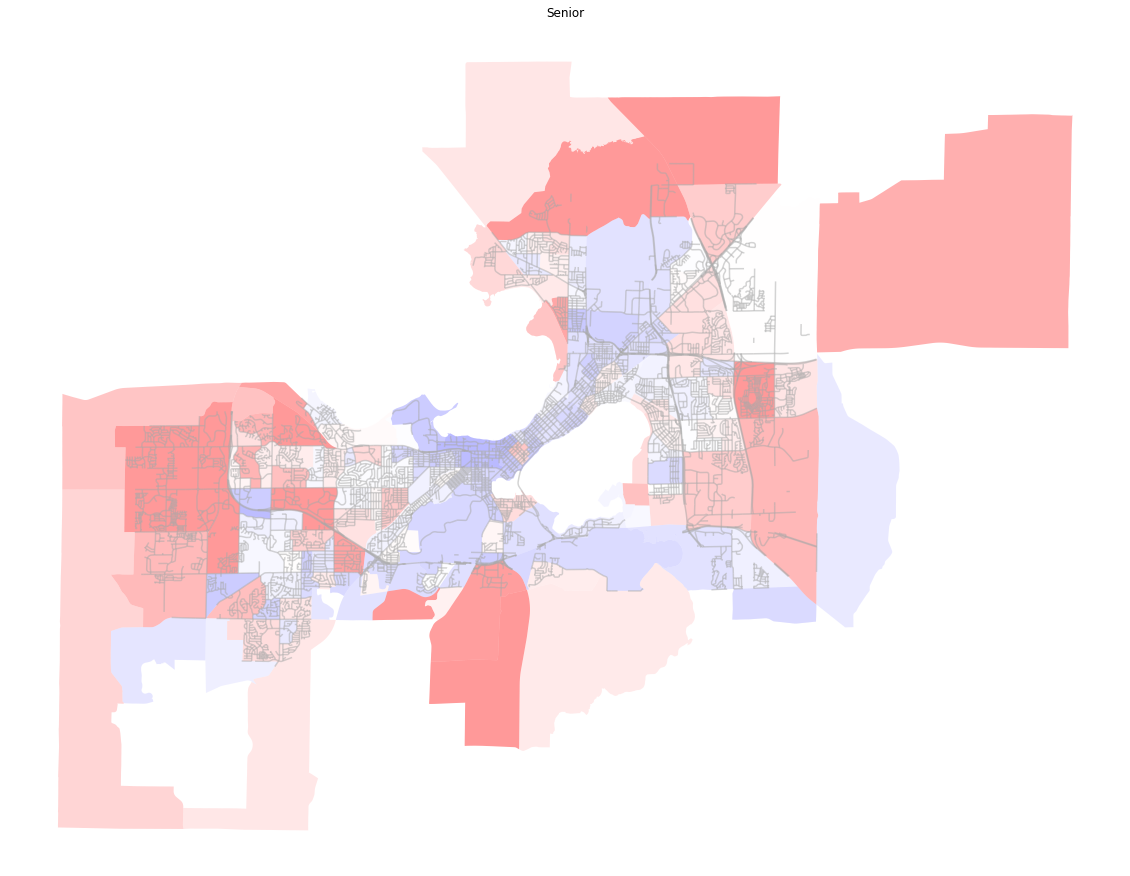

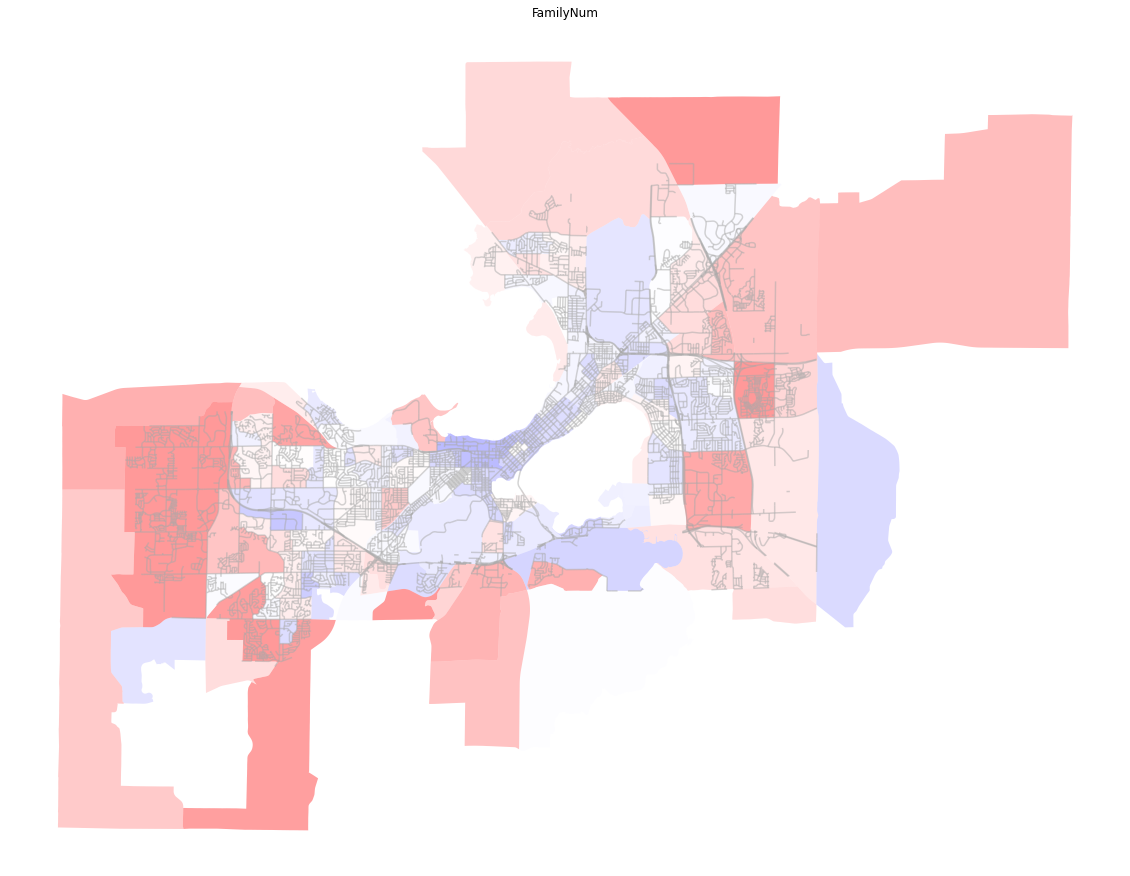

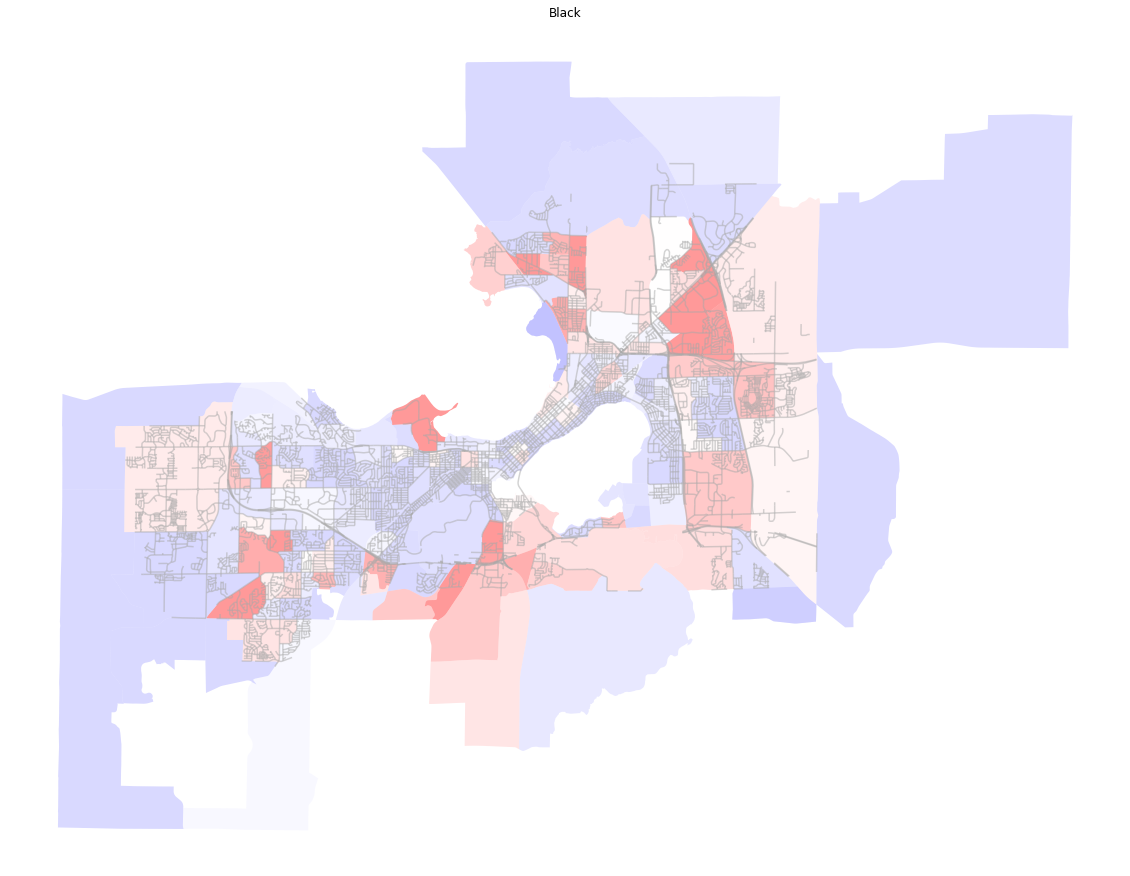

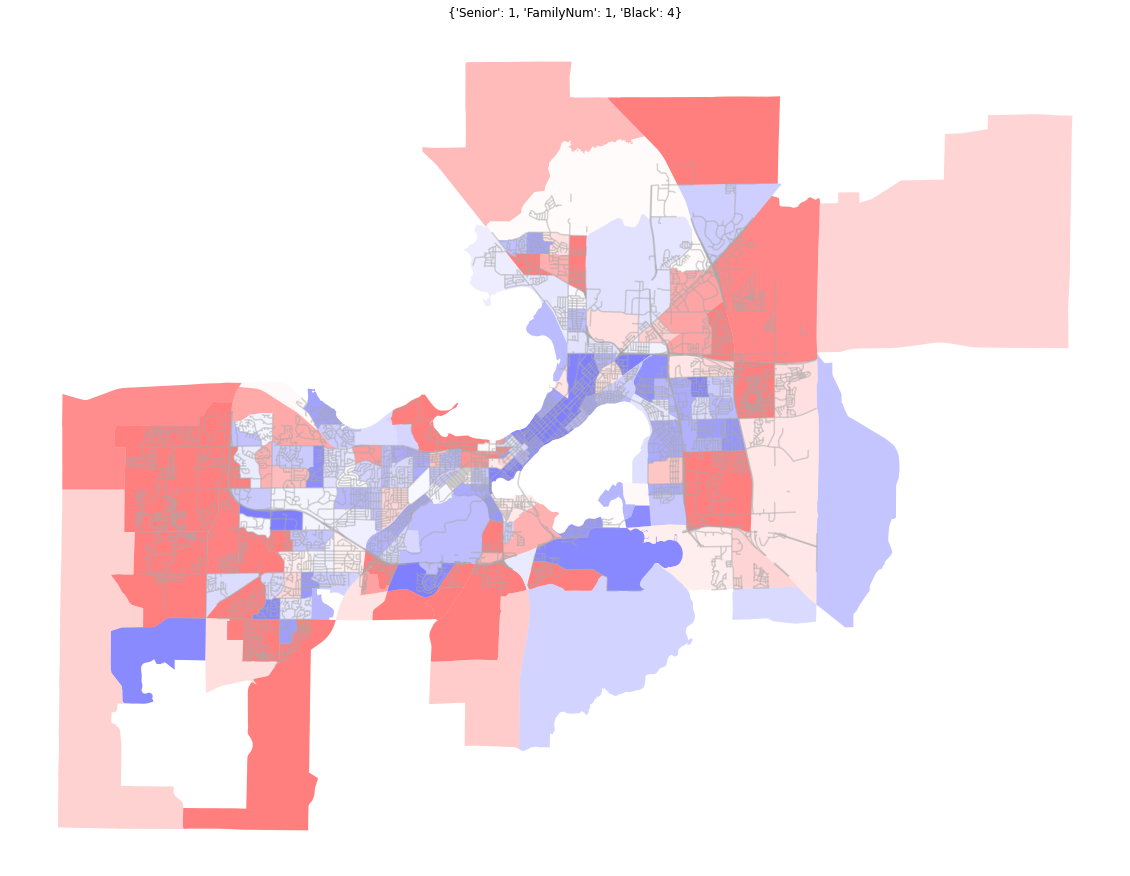

In [63]:
ax,df,df_all = utilityMap({"Senior":1,'FamilyNum':1,'Black':4},12)

[81.0, 44.0, 44.0, 194.0]
[76.0, 83.0]


c:\pathon\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()
c:\pathon\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()


[124.0, 124.0]
[136.0, 132.0]


c:\pathon\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()
c:\pathon\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()


[26.0, 25.0]


c:\pathon\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()


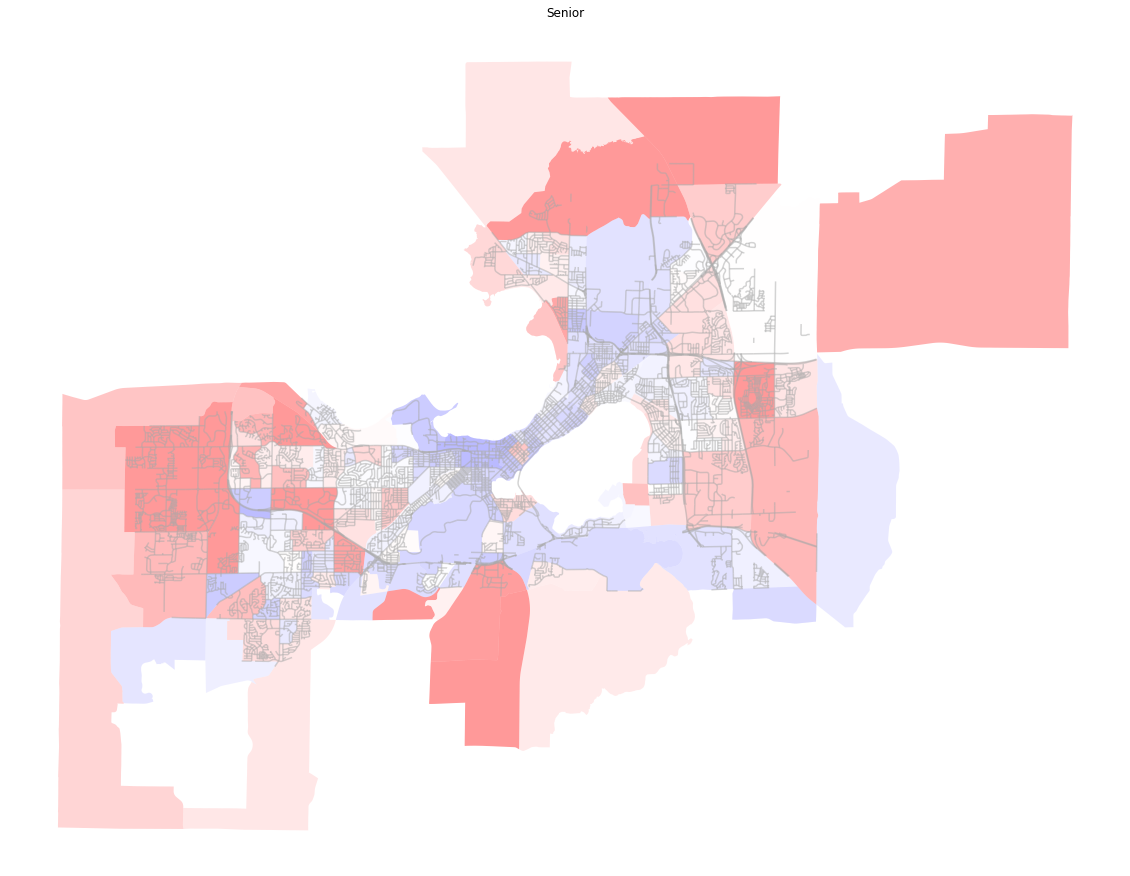

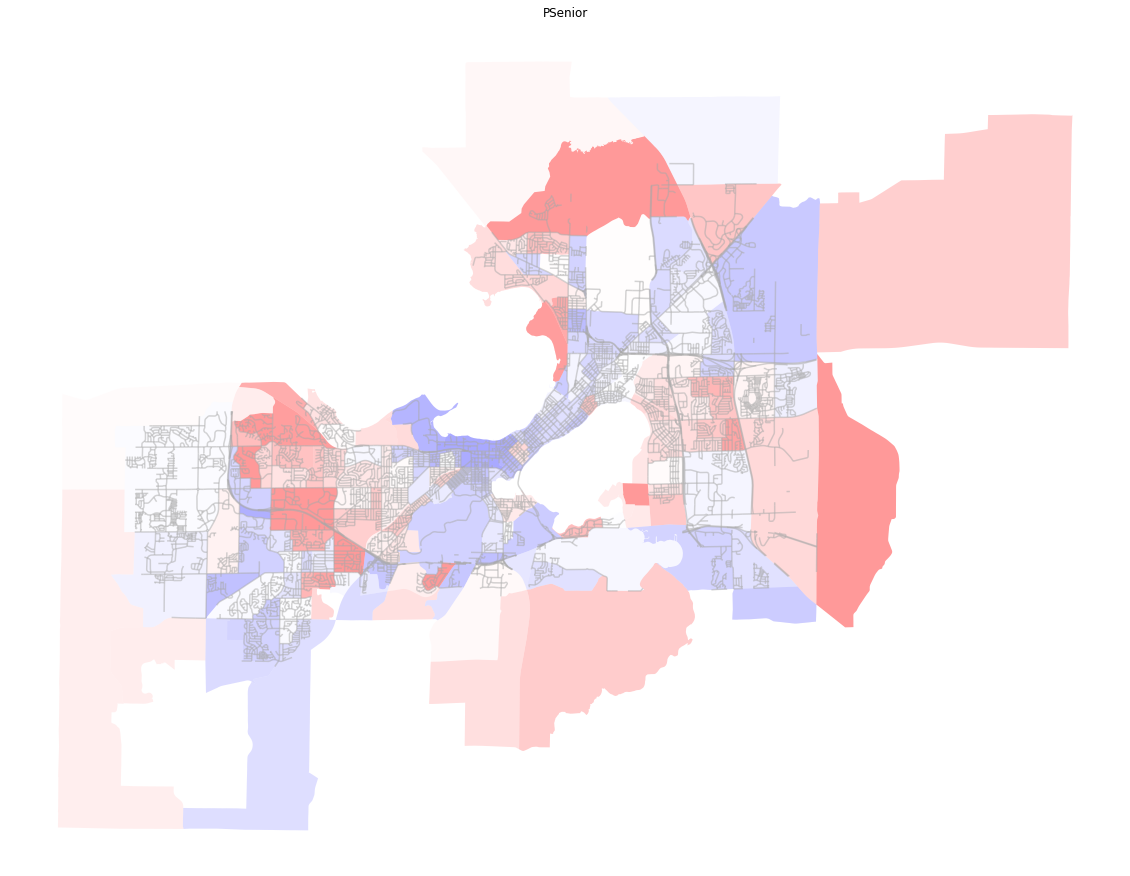

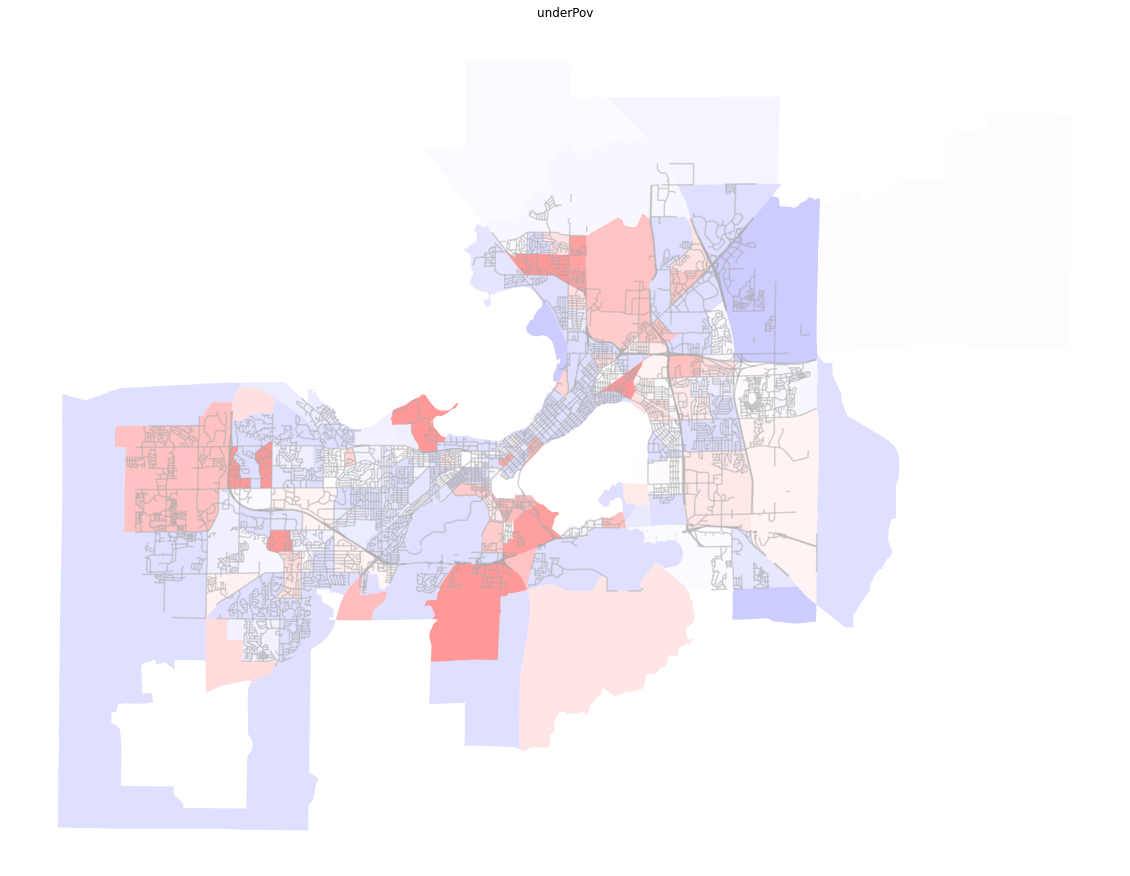

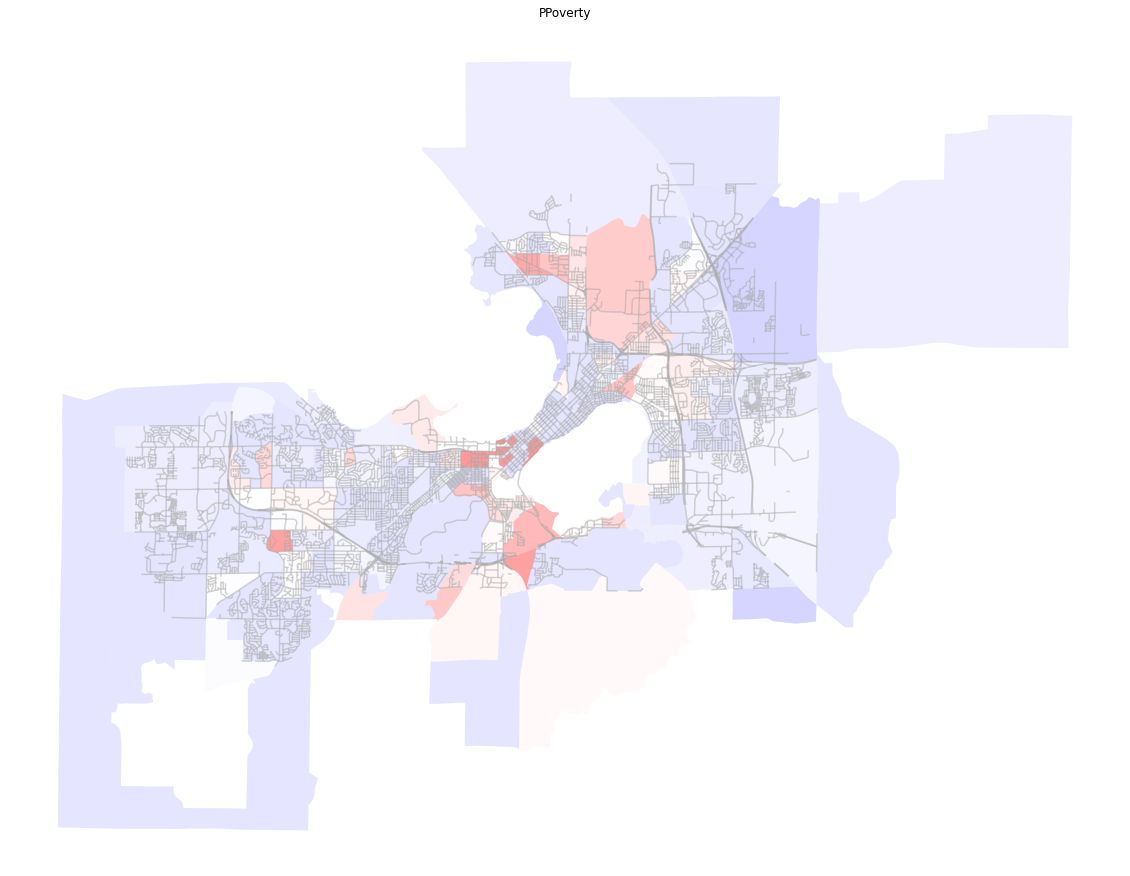

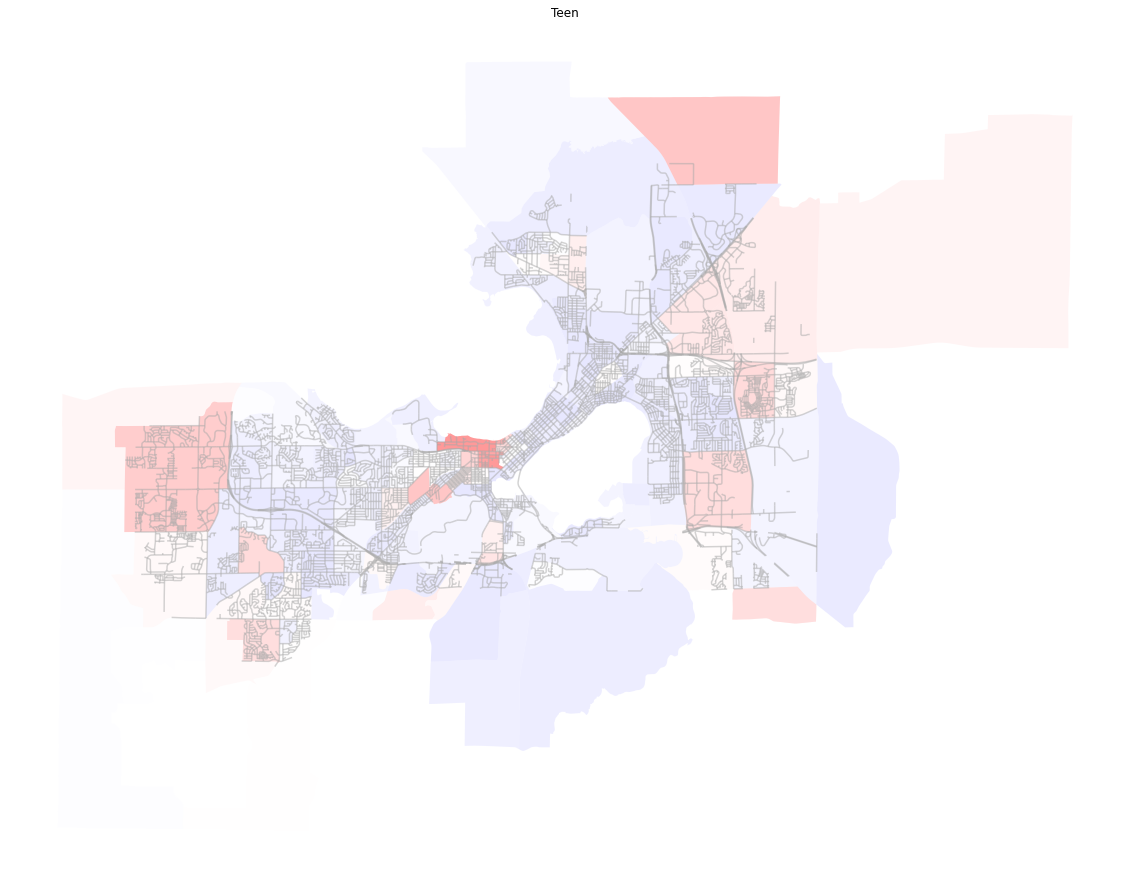

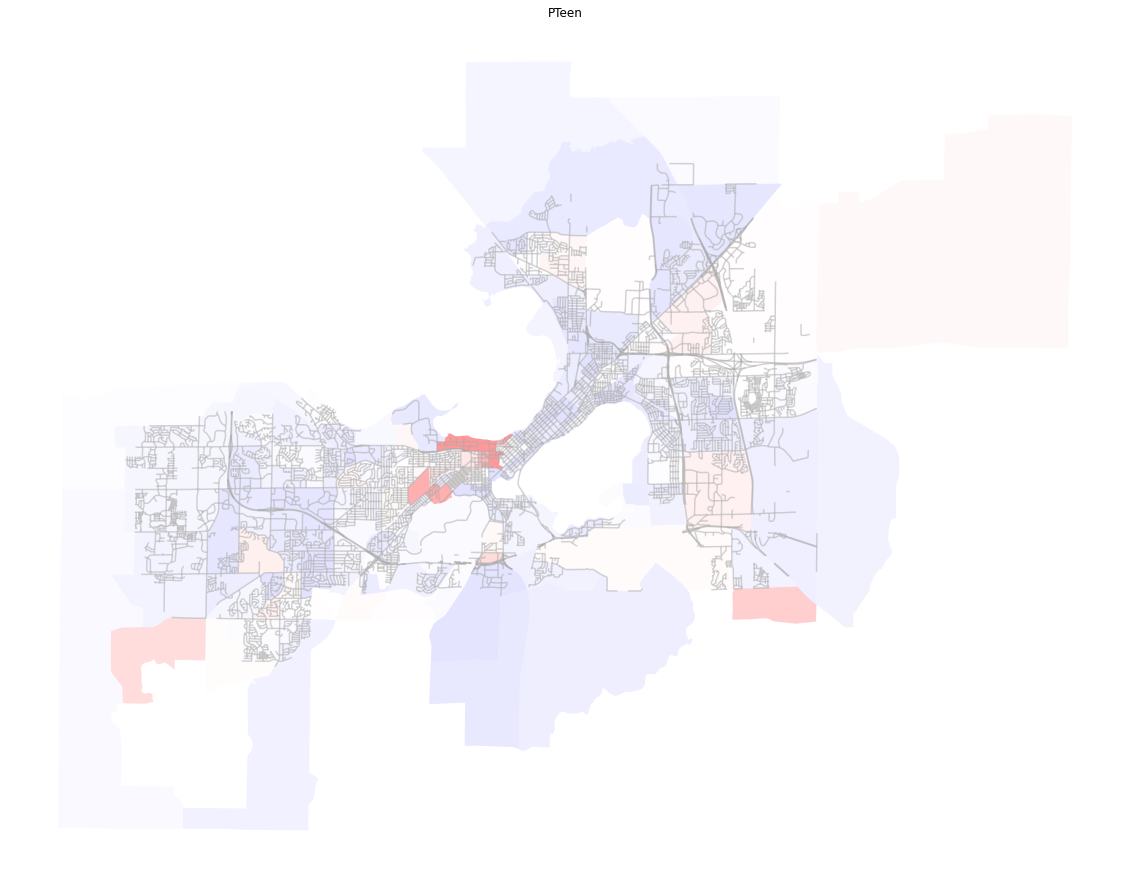

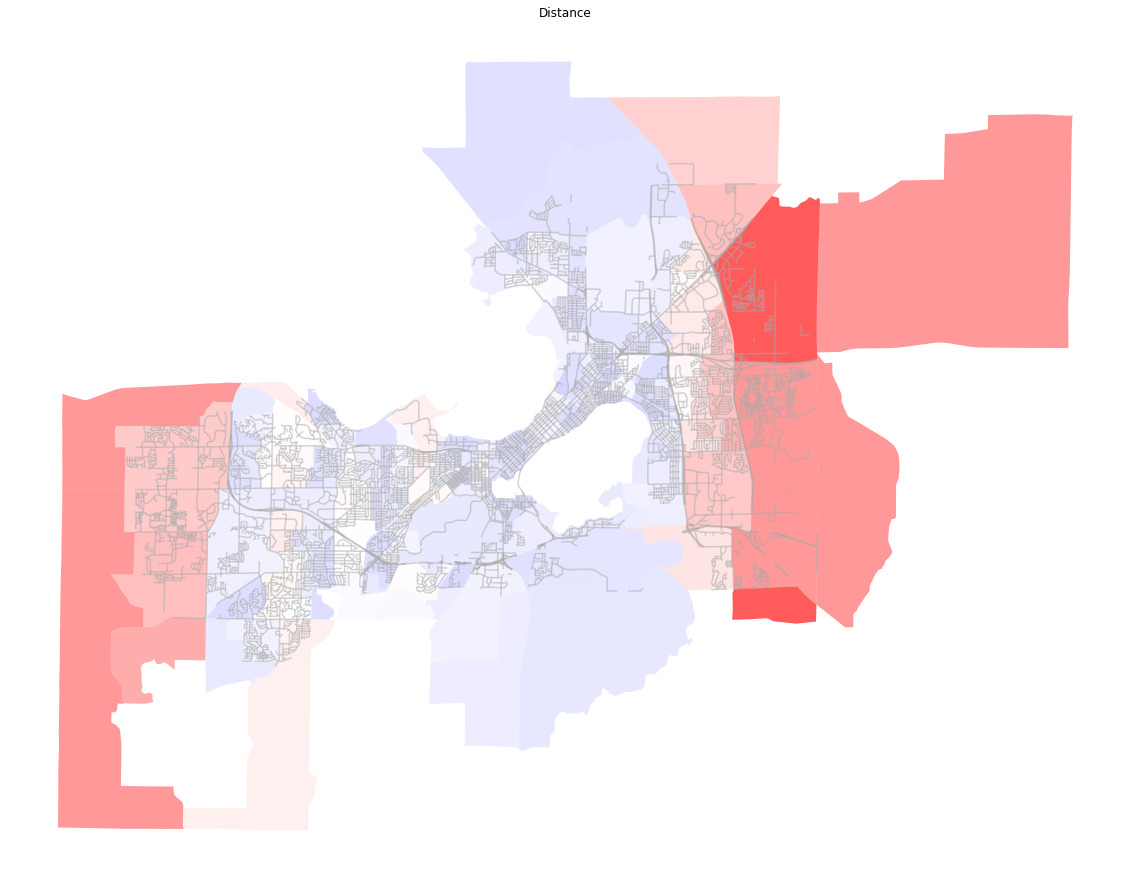

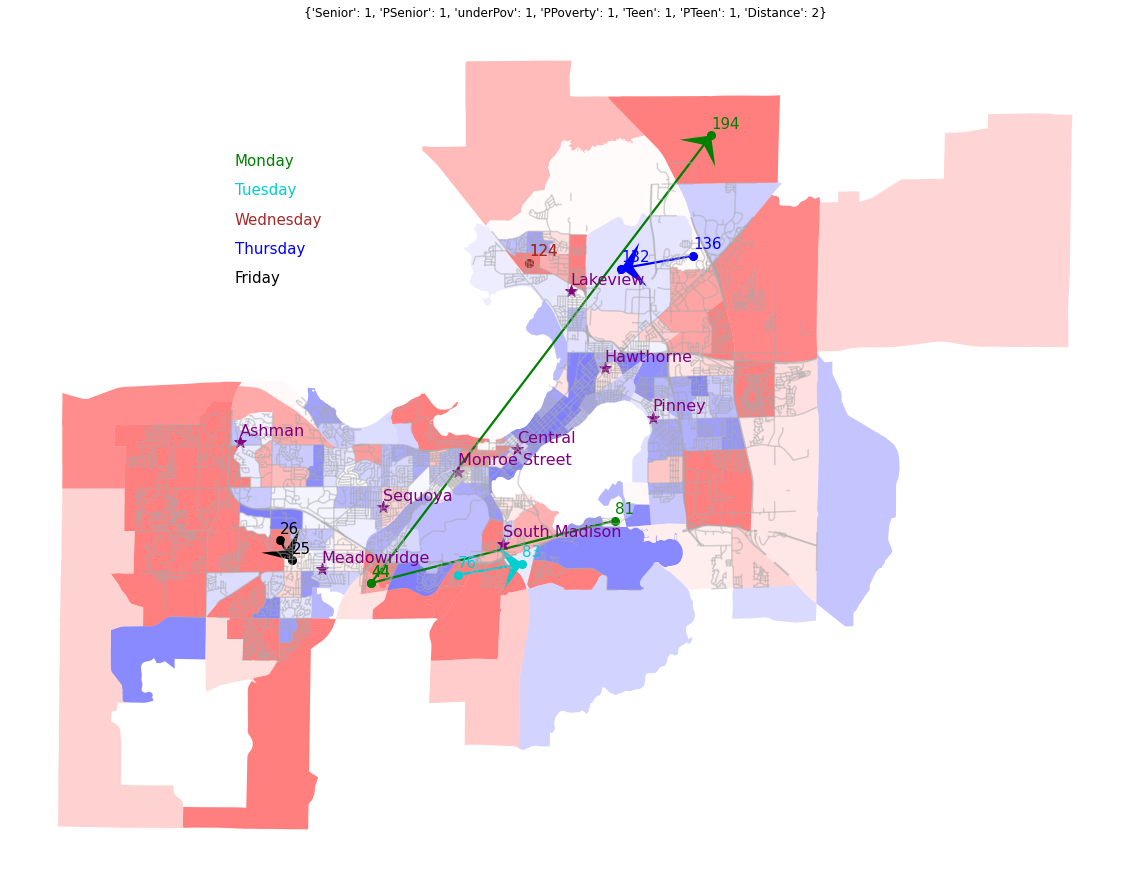

Monday  Tuesday  Wednesday  Thursday  Friday
1pm    81.0     76.0      124.0     136.0    26.0
2pm    44.0     83.0      124.0     132.0    25.0
3pm    44.0      NaN        NaN       NaN     NaN
4pm   194.0      NaN        NaN       NaN     NaN

In [61]:
ax,df,df_all = utilityMap({"Senior":1,"PSenior":1,"underPov":1,"PPoverty":1,'Teen':1,'PTeen':1,
                           'Distance':2},12)

df_dict = {}
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekindex = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4}
colorDay = {'Monday':"green", 'Tuesday':"DarkTurquoise", 'Wednesday':"brown", 'Thursday':"blue", 'Friday':"black"}


    
for day in weekday:   
    schlist= [x for x in schedule[day].to_list() if x >-1]
    print(schlist)
    #df = gpd.GeoDataFrame(df_dict[day],geometry = df_dict[day].geometry)
    df = df_all.loc[schlist,:]
    df = gpd.GeoDataFrame(df.centroid,columns =["centroid"])
    df.centroid.plot(ax=ax,markersize=65,color = colorDay[day],label=df.index)
    df = lonlat(df)
    for idx,row in df.iterrows():
        plt.text(row.lon,row.lat*1.00006,str(int(idx)),size=15,color = colorDay[day])
    plot_line(ax, df.iloc[:-1,],color = colorDay[day])
    #plot_line(ax, df.iloc[1:,],color = colorDay[day])
    #plt.text(df.iloc[:2,:]["centroid"].x.sum()/2,df.iloc[:2]["centroid"].y.sum()/2,day,s = 5,ax = ax)
    plot_line_arrow(ax, df.iloc[-2:],color = colorDay[day])
    
df_coo=pd.read_excel('lib coor.xlsx')
gdf = gpd.GeoDataFrame(
     df_coo, geometry=gpd.points_from_xy(df_coo.Longitude, df_coo.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf.plot(ax=ax,marker='*', color='Purple',markersize=150)

gdf_lgd = pd.DataFrame([[43.17,-89.517674],[43.17,-89.479143],
                      [43.16,-89.517674],[43.16,-89.479143],
                       [43.15,-89.517674],[43.15,-89.479143],
                        [43.14,-89.517674],[43.14,-89.479143],
                        [43.13,-89.517674],[43.13,-89.479143]
                        ],columns=["Latitude","Longitude"])
gdf_lgd = gpd.GeoDataFrame(
     gdf_lgd, geometry=gpd.points_from_xy(gdf_lgd.Longitude, gdf_lgd.Latitude))

gdf_lgd = gdf_lgd.set_crs("EPSG:4326")



for i in range(len(df_coo)):
      plt.text(df_coo.Longitude[i],df_coo.Latitude[i]*1.00006,str(df_coo.Library[i]),color='Purple',size=16)

#plot_line_1(ax, gdf_lgd[:2],'green')
plt.text(-89.5-0.02, 43.17+0.001,'Monday',size=15,color='green')
#plot_line_1(ax, gdf_lgd[2:4],'red')
plt.text(-89.5-0.02, 43.16+0.001,'Tuesday',size=15,color='DarkTurquoise')
#plot_line_1(ax, gdf_lgd[4:6],'brown')
plt.text(-89.5-0.02, 43.15+0.001,'Wednesday',size=15,color='brown')
#plot_line_1(ax, gdf_lgd[6:8],'blue')
plt.text(-89.5-0.02, 43.14+0.001,'Thursday',size=15,color='blue')
#plot_line_1(ax, gdf_lgd[8:],'black')
plt.text(-89.5-0.02, 43.13+0.001,'Friday',size=15,color='black')

plt.show()
schedule
#scoreSchedule(schedule)

In [94]:
schedule

Monday  Tuesday  Wednesday  Thursday  Friday
4pm   194.0     23.0      179.0      79.0   130.0
5pm    80.0    124.0       78.0      63.0   181.0
6pm   158.0    180.0       97.0      72.0   189.0
7pm    76.0    174.0      139.0       NaN    41.0

In [ ]:
df_choose

In [ ]:
test_other(df_choose.index.to_list())

In [ ]:
test_other(df_choose.index.to_list())

In [ ]:
print(df_all[df_all['utility_map']>0].index.tolist())

In [ ]:
test_other([24, 26, 28, 29, 135, 136, 138, 139, 140, 152, 174,175, 132, 135, 136])